## Importing liberaries

In [230]:
import os
import tensorflow as tf
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, Bidirectional, MaxPooling1D, GlobalAveragePooling1D, AdditiveAttention, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AdditiveAttention, Concatenate, BatchNormalization, Attention, Activation, MultiHeadAttention
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

## Loading the data

In [231]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


In [ ]:


# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_text.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

In [ ]:
all_texts_length = X_df['Processed'].apply(lambda x: len(x.split()))
# Now, let's analyze the distribution of these sequence lengths
all_texts_length.describe()

count    12854.000000
mean        23.089311
std         86.574861
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max       2292.000000
Name: Processed, dtype: float64

In [ ]:
X = X.flatten()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='<OOV>') # Hyperparameters = num_words=vocab_size, oov_token=oov_tok
tokenizer.fit_on_texts(X)

#Creating a word index of the words from the tokenizer 
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.\n\nFirst 10 is listen below:')
print(dict(list(word_index.items())[0:10]))

Found 22234 unique tokens.

First 10 is listen below:
{'<OOV>': 1, 'people': 2, 'like': 3, 'work': 4, 'right': 5, 'trump': 6, 'think': 7, 'state': 8, 'government': 9, 'party': 10}


In [ ]:
# Defining pre-processing hyperparameters for the networks
max_len = 2292
trunc_type = "post"
padding_type = "post"
vocab_size = len(word_index)
# This is fixed.
embedding_dim = 100


In [ ]:
# Encoding the sequences from the reddit posts
X = tokenizer.texts_to_sequences(X)
# Padding the sequences to keep the lengths uniform
X = pad_sequences(X, maxlen=max_len, padding=padding_type, truncating=trunc_type)
# print('Shape of data tensor:', X_tensorflow.shape)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [ ]:
# Loading the params from CNN-LSTM from the saved JSON-fil
with open(r'C:\Users\bugat\Prosjekter\Tekstanalyse\git_NLP\Tekstanalyse\git_NLP_Notebooks\Hypertuning_trials\best_trial_1.json', 'r') as f:
    data = json.load(f)
    params = data['params']

## The LSTM-CNN model with tuned hyperparameters and attention layer

In [ ]:
# extracting the parameters
lstm_units = params['lstm_units']
dense_1_units = params['dense_1_units']
dense_2_units = params['dense_2_units']
dropout_rate = params['dropout_rate']
learning_rate = params['learning_rate']


In [ ]:
def CNN_LSTM_sequential(max_len, lstm_units, dense_1_units, dense_2_units, dropout_rate, learning_rate):
    # Model architecture
    input_layer = Input(shape=(max_len,))
    embedding = Embedding(input_dim=embeddings_GloVe.shape[0],
                          output_dim=embeddings_GloVe.shape[1],
                          weights=[embeddings_GloVe],
                          trainable=False)(input_layer)
    
    spatial_dropout = SpatialDropout1D(0.2)(embedding)
    conv1d = Conv1D(filters=64, kernel_size=1, activation='relu')(spatial_dropout)
    dense = Dense(dense_1_units, activation='relu')(conv1d)
    max_pooling = MaxPooling1D()(dense)
    lstm = Bidirectional(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid',
                              recurrent_dropout=0.1, return_sequences=True))(max_pooling)
    
    #Adding a attention layer for potential improvements
    #Using scaling to normalize the values and prevent extreme values 
    attention_layer = AdditiveAttention(use_scale=True)
    attention_output = attention_layer([lstm, lstm], return_attention_scores=False)
    # attention_output = GlobalAveragePooling1D()(attention_output)
    
    dense = Dense(dense_2_units, activation='relu')(attention_output)
    dropout = Dropout(dropout_rate)(dense)
    output_layer = Dense(num_classes, activation='sigmoid')(dropout)

    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    
    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, Concatenate, AdditiveAttention
from tensorflow.keras.optimizers import Adam

def CNN_LSTM_parallel(max_len, lstm_units, dense_2_units, dropout_rate, learning_rate, num_classes, embeddings_GloVe):
    input_layer = Input(shape=(max_len,), dtype='int32')
    
    embedding = Embedding(input_dim=embeddings_GloVe.shape[0],
                                   output_dim=embeddings_GloVe.shape[1],
                                   weights=[embeddings_GloVe],
                                   trainable=False)(input_layer)
    dropout = SpatialDropout1D(0.1)(embedding)
    # Convolutional branch
    conv = Conv1D(filters=74, kernel_size=1, activation='relu')(dropout)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = GlobalAveragePooling1D()(conv)
    
    # LSTM and Attention branch
    lstm = Bidirectional(LSTM(lstm_units, return_sequences=True, recurrent_dropout=0.00))(embedding)
    lstm = BatchNormalization()(lstm)
    
    # num_heads = 2  # This should divide embed_dim evenly

    # attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embeddings_GloVe.shape[1] // num_heads, dropout=0.1)

    # attention_layer = Attention(use_scale=True)
    attention_layer = AdditiveAttention(use_scale=True)
    attention_output = attention_layer([lstm, lstm], return_attention_scores=False)
    # attention_output = attention_layer(query=lstm, key=lstm, value=lstm)
    attention_output = GlobalAveragePooling1D()(attention_output)
    
    # Concatenation of both branches
    concatenated = Concatenate()([conv, attention_output])
    dense_layer = Dense(dense_2_units, activation='relu')(concatenated)
    dropout_layer = Dropout(dropout_rate)(dense_layer)
    output_layer = Dense(num_classes, activation='sigmoid')(dropout_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    
    return model

In [ ]:
num_classes = 1
EPOCHS=20
BATCH_SIZE = 32

model = CNN_LSTM_parallel(max_len, lstm_units, dense_2_units, dropout_rate, learning_rate, num_classes, embeddings_GloVe)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.000001)


history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_callback)

Epoch 1/20
282/282 [==============================] - 134s 431ms/step - loss: 0.6210 - accuracy: 0.6666 - val_loss: 0.6173 - val_accuracy: 0.6499
Epoch 2/20
282/282 [==============================] - 121s 430ms/step - loss: 0.5396 - accuracy: 0.7284 - val_loss: 0.5246 - val_accuracy: 0.7355
Epoch 3/20
282/282 [==============================] - 121s 428ms/step - loss: 0.4910 - accuracy: 0.7593 - val_loss: 0.5559 - val_accuracy: 0.7070
Epoch 4/20
282/282 [==============================] - 121s 428ms/step - loss: 0.4403 - accuracy: 0.7914 - val_loss: 0.5062 - val_accuracy: 0.7521
Epoch 5/20
282/282 [==============================] - 119s 423ms/step - loss: 0.3866 - accuracy: 0.8187 - val_loss: 0.5273 - val_accuracy: 0.7510
Epoch 6/20
282/282 [==============================] - 120s 427ms/step - loss: 0.3291 - accuracy: 0.8469 - val_loss: 0.5387 - val_accuracy: 0.7599
Epoch 7/20
282/282 [==============================] - 118s 420ms/step - loss: 0.2713 - accuracy: 0.8784 - val_loss: 0.5533 -

In [ ]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_39 (Embedding)    (None, 100, 100)             2223500   ['input_40[0][0]']            
                                                                                                  
 spatial_dropout1d_6 (Spati  (None, 100, 100)             0         ['embedding_39[0][0]']        
 alDropout1D)                                                                                     
                                                                                                  
 conv1d_39 (Conv1D)          (None, 100, 64)              6464      ['spatial_dropout1d_6[0

## Evaluation of the model

61/61 [==============================] - 7s 115ms/step - loss: 0.8520 - accuracy: 0.7652
Test Loss: 0.8519680500030518
Test Accuracy: 0.7651633024215698


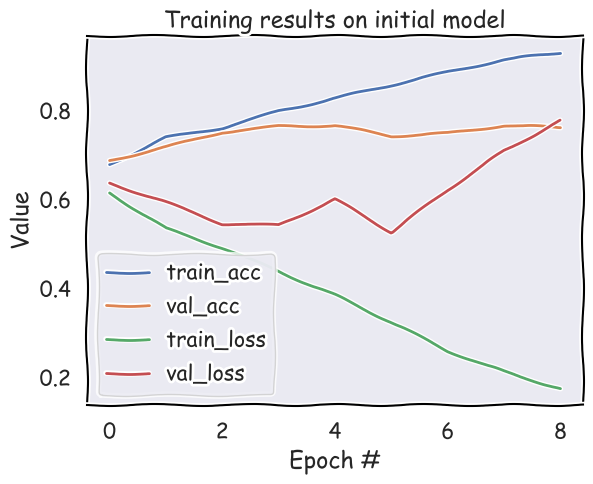

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

## Classification metrics

31/31 [==============================] - 7s 221ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.52      0.60       665
           1       0.78      0.89      0.83      1264

    accuracy                           0.77      1929
   macro avg       0.75      0.71      0.72      1929
weighted avg       0.76      0.77      0.75      1929

Accuracy: 0.7651632970451011
Recall: 0.8947784810126582
Precision: 0.7794624396967609
F1 Score: 0.8331491712707182


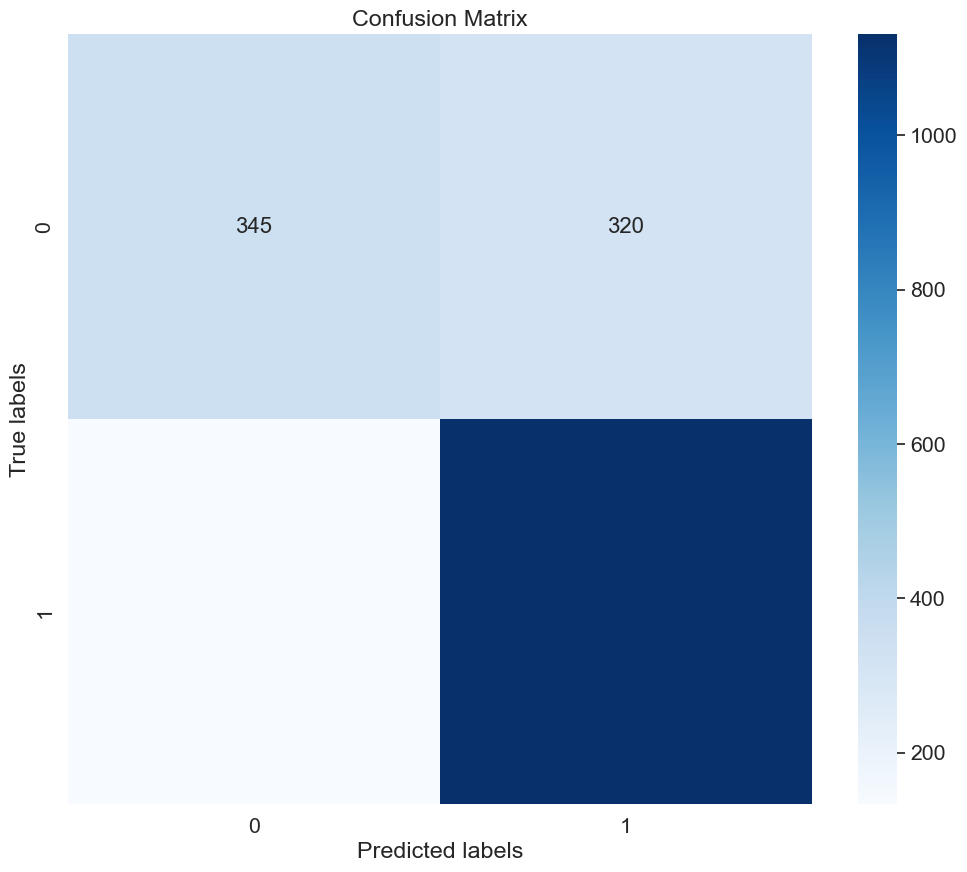

In [ ]:
# Predict probabilities for the positive class (class 1)
probabilities = model.predict(X_test, batch_size=64)

# Ensure that probabilities are in the expected format
# y_pred = (probabilities > 0.5).astype(int).flatten()
y_pred = (probabilities[:, 0] > 0.5).astype(int)  # Indexing the first column if necessary


# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculating different metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print each metric
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Creating a confusion matrix for visualization
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')  # fmt='g' to avoid scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()